#### This notebook propose a weighted loss function for the model with a toy example
##### Author: Omid Emamjomehzadeh (https://www.omidemam.com/)
##### Supervisor: Dr. Omar Wani (https://engineering.nyu.edu/faculty/omar-wani)
##### Hydrologic Systems Group @NYU (https://www.omarwani.com/)

In [1]:
# Load libraries
import os
from PIL import Image
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from glob import glob
from watermark import watermark
import datetime
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt


The steps to compute the new loss using ECDF-based weighting for a single cell are as follows. To improve computational efficiency, it is preferable not to iterate over all cells repeatedly. Instead, first compute the ECDF values for all pixels and store them. Then, for each day of analysis, calculate the corresponding weight image using the formula   $w(x) = \frac{1}{1 - F(x)}$, and save it. Once the model calculates the loss image as before, compute the final weighted loss by taking the dot product of the loss image and the precomputed weight image.
1. **Compute ECDF**:  
   For each cell value in the input dataset, compute the empirical cumulative distribution function (ECDF). Let the ECDF of the rainfall input value \(x\) be denoted as \(F(x)\).

2. **Generate the loss image**:  
   Create a loss image as it is calculated befor.

3. **Compute weight image**:  
   For each pixel, calculate the weighting factor based on the ECDF as:  
   $$
   w(x) = \frac{1}{1 - F(x)}
   $$

4. **Weighted dot product**:  
   Multiply the loss image and the weight image element-wise to get the weighted loss image:
   $$
   \text{Weighted Loss Image} = \text{Loss} \cdot \frac{1}{1 - F(x)}
   $$

5. **Compute mean loss**:  
   Take the mean of all the pixel values in the weighted loss image:
   $$
   \text{Mean Loss} = \frac{1}{mn} \sum_{i=1}^{m} \sum_{j=1}^{n} \left( \text{Loss}_{ij} \cdot \frac{1}{1 - F(x_{ij})} \right)
   $$

$$
\text{Let } x_{ij} \text{ represent the 24-hour rainfall at cell } (i, j), \text{ and let } F(x_{ij}) \text{ denote the ECDF value evaluated at } x_{ij}.
$$


# Calculaiton of ecdf, and the weighted loss for one cell 


Loading hourly rainfall: 100%|██████████| 46/46 [01:02<00:00,  1.35s/it]


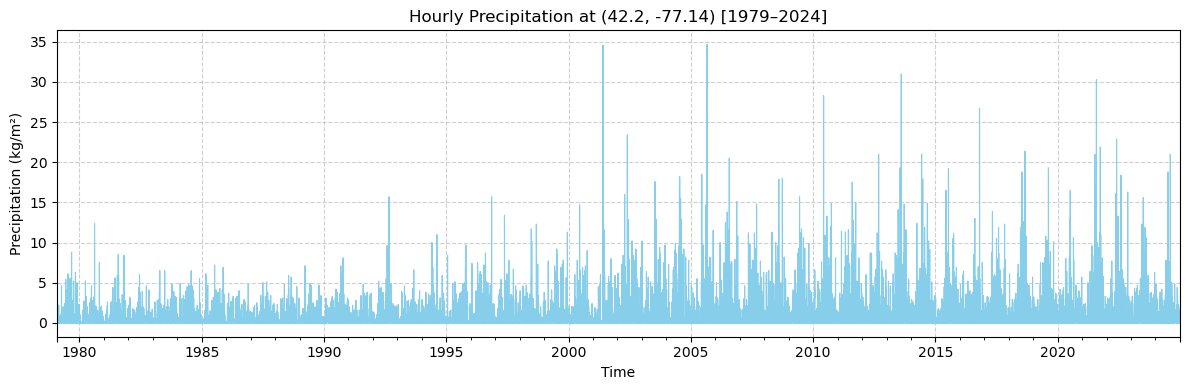

In [2]:
# for each cell we need the timeseries of values of that cell since its a toy example I use aorc for a random location in NYS to retrive the timeseries you can either do the same for the center location of each cell.
# Coordinates
lat_nys = 42.2
lon_nys = -77.14

# Dataset setup
base_url = 's3://noaa-nws-aorc-v1-1-1km'
var = 'APCP_surface'
start_year = 1979
end_year = 2024

# Download and extract hourly rain at the given location
all_ts = []
for year in tqdm(range(start_year, end_year + 1), desc="Loading hourly rainfall"):
    url = f"{base_url}/{year}.zarr/"
    ds = xr.open_zarr(url, consolidated=True, storage_options={"anon": True})
    precip_ts = ds[var].sel(latitude=lat_nys, longitude=lon_nys, method='nearest')
    all_ts.append(precip_ts.to_series())

# Combine into one continuous time series
hourly_rain = pd.concat(all_ts)

# Plot the time series
plt.figure(figsize=(12, 4))
hourly_rain.plot(color='skyblue', linewidth=0.8)
plt.title(f"Hourly Precipitation at ({lat_nys}, {lon_nys}) [1979–2024]")
plt.ylabel("Precipitation (kg/m²)")
plt.xlabel("Time")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

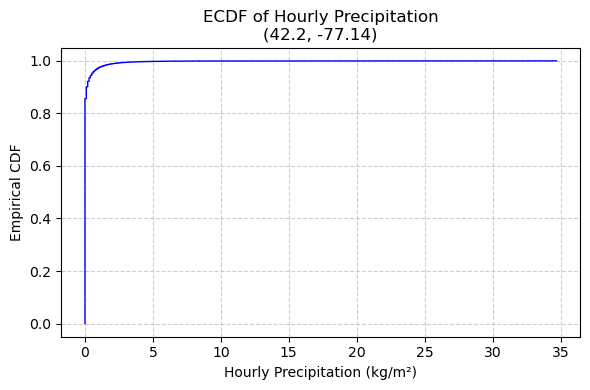

In [3]:
# Drop NaNs from the series
hourly_rain_clean = hourly_rain.dropna()

# Create ECDF object
ecdf = ECDF(hourly_rain_clean)

# Plot ECDF
plt.figure(figsize=(6, 4))
plt.plot(ecdf.x, ecdf.y, color='blue', linewidth=1)
plt.xlabel("Hourly Precipitation (kg/m²)")
plt.ylabel("Empirical CDF")
plt.title(f"ECDF of Hourly Precipitation\n({lat_nys}, {lon_nys})")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
#Suposse this cell has the MSE of 1.5 for the input rainfall of 3 then the revised error will be 
print((1/(1-ecdf(3)))*1.5)
#Suposse this cell has the MSE of 0.25 for the input rainfall of 0.5 then the revised error will be 
print((1/(1-ecdf(0.5)))*0.25)


200.65425841296334
7.2682437923250625


Although the ratio of MAE to input rainfall remains the same in the scenario above, the losses are scaled based on the rarity of the event. In this approach, rarer events—which the model encounters less frequently—are assigned proportionally higher losses. As a result, the model is encouraged to learn across all quantiles more effectively, rather than focusing primarily on frequent events, as it would when minimizing MSE alone.



In [9]:
# Date and time
now = datetime.datetime.now()
print(f"Date and time: {now}")

Date and time: 2025-08-06 16:33:45.794222


In [8]:
%load_ext watermark
# Print Python version and some dependencies
%watermark -v -m -p PIL,xarray,numpy,watermark,matplotlib,geopandas,pandas

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.20.0

PIL       : 10.4.0
xarray    : 2024.7.0
numpy     : 2.0.2
watermark : 2.4.3
matplotlib: 3.8.4
geopandas : 1.0.1
pandas    : 2.2.2

Compiler    : MSC v.1940 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : Intel64 Family 6 Model 183 Stepping 1, GenuineIntel
CPU cores   : 24
Architecture: 64bit

